In [160]:
import sys
sys.path.append('../scripts/')
from mcl import *
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

In [164]:
def sigma_ellipse(p, cov, n):  ###kf3calculation
    eig_vals, eig_vec = np.linalg.eig(cov)
    ang = math.atan2(eig_vec[:,0][1], eig_vec[:,0][0])/math.pi*180
    return Ellipse(p, width=2*n*math.sqrt(eig_vals[0]),height=2*n*math.sqrt(eig_vals[1]), angle=ang, fill=False, color="blue", alpha=0.5)

def matM(nu, omega, time, stds):
    return np.diag([stds["nn"]**2*abs(nu)/time + stds["no"]**2*abs(omega)/time, 
                               stds["on"]**2*abs(nu)/time + stds["oo"]**2*abs(omega)/time])
    
def matA(nu, omega, time, theta):
    st, ct = math.sin(theta), math.cos(theta)
    stw, ctw = math.sin(theta + omega*time), math.cos(theta + omega*time)
    return np.array([[(stw - st)/omega,    -nu/(omega**2)*(stw - st) + nu/omega*time*ctw],
                                 [(-ctw + ct)/omega, -nu/(omega**2)*(-ctw + ct) + nu/omega*time*stw],
                                 [0,                                time]] )

def matF(nu, omega, time, theta):
    F = np.diag([1.0, 1.0, 1.0])
    F[0, 2] = nu / omega * (math.cos(theta + omega * time) - math.cos(theta))
    F[1, 2] = nu / omega * (math.sin(theta + omega * time) - math.sin(theta))
    return F


[[1.e-10 0.e+00 0.e+00]
 [0.e+00 1.e-10 0.e+00]
 [0.e+00 0.e+00 1.e-10]]
[[1.e-10 0.e+00 0.e+00]
 [0.e+00 1.e-10 0.e+00]
 [0.e+00 0.e+00 1.e-10]]
[[1.e-10 0.e+00 0.e+00]
 [0.e+00 1.e-10 0.e+00]
 [0.e+00 0.e+00 1.e-10]]


<IPython.core.display.Javascript object>


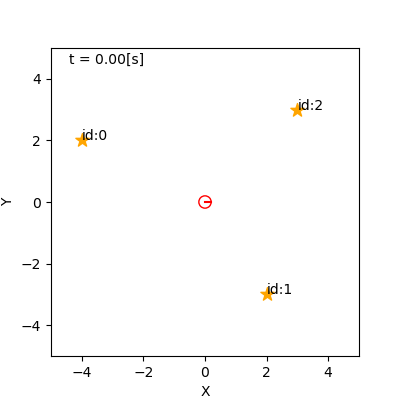

<IPython.core.display.Javascript object>


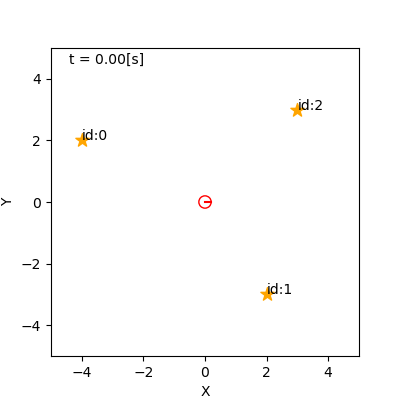

<IPython.core.display.Javascript object>


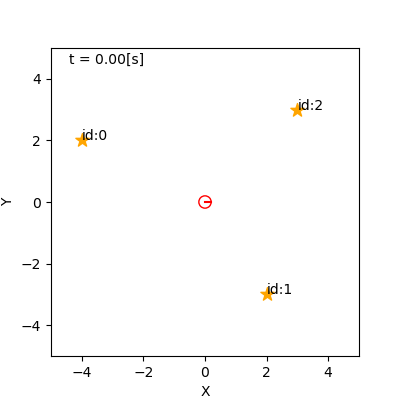

<IPython.core.display.Javascript object>


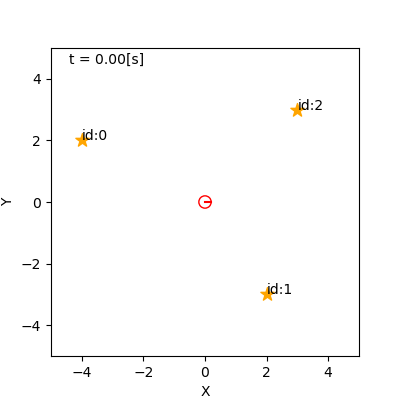

<IPython.core.display.Javascript object>


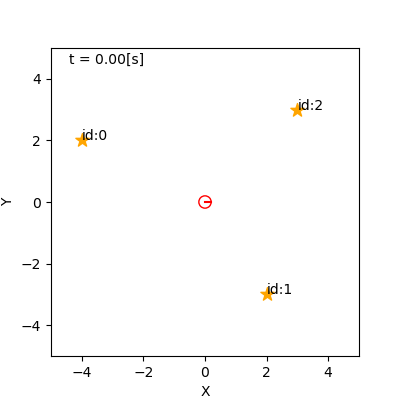

<IPython.core.display.Javascript object>


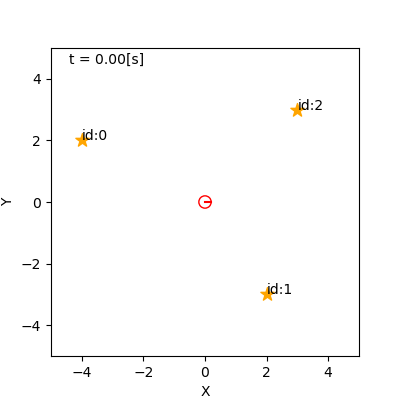

<IPython.core.display.Javascript object>


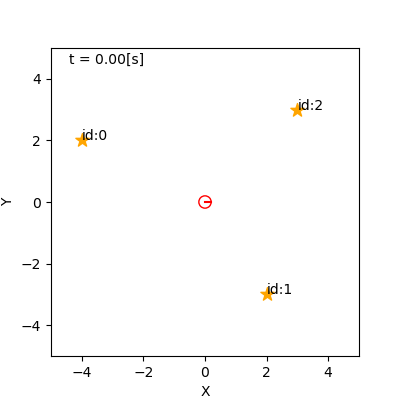

<IPython.core.display.Javascript object>


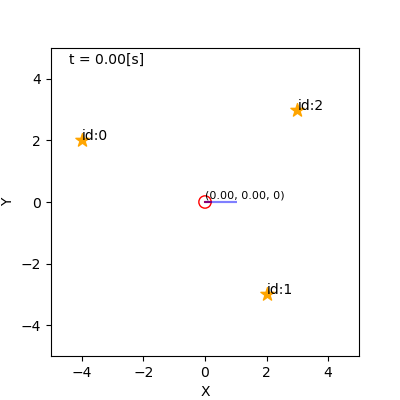

<IPython.core.display.Javascript object>


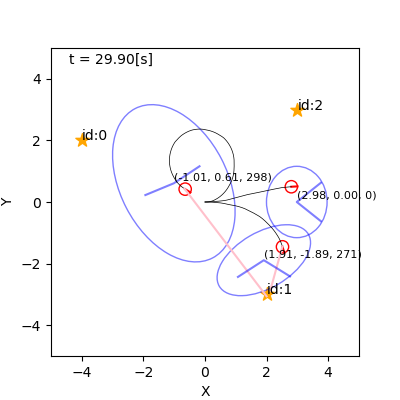

<IPython.core.display.Javascript object>


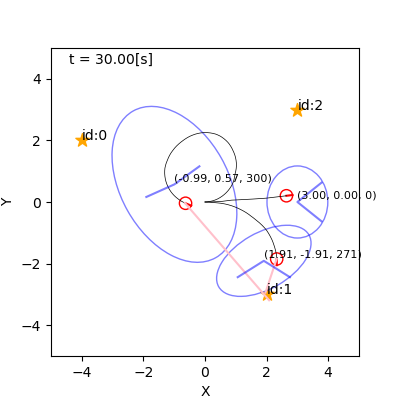

In [226]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(30, time_interval, debug=False) 

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ### ロボットを作る ###
    initial_pose = np.array([0, 0, 0]).T
    kf = KalmanFilter(m, initial_pose)
    circling = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, kf)
    r = Robot(initial_pose, sensor=Camera(m), agent=circling, color="red")
    world.append(r)
    
    kf = KalmanFilter(m, initial_pose)
    linear = EstimationAgent(time_interval, 0.1, 0.0, kf)
    r = Robot(initial_pose, sensor=Camera(m), agent=linear, color="red")
    world.append(r)
    
    kf = KalmanFilter(m, initial_pose)
    right = EstimationAgent(time_interval, 0.1, -3.0/180*math.pi, kf)
    r = Robot(initial_pose, sensor=Camera(m), agent=right, color="red")
    world.append(r)

    world.draw()
    

In [ ]:
#['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_dist', 'cdf', 'cov_object', 'entropy', 'logcdf', 'logpdf', 'maxpts', 'mean', 'pdf', 'random_state', 'releps', 'rvs']

In [224]:
class KalmanFilter:   ###kfmotionupdate
    def __init__(self, envmap, init_pose, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):
        self.belief = multivariate_normal(mean=np.array([0.0, 0.0, 0.0]), cov=np.diag([1e-10, 1e-10, 1e-10]))
        print(self.belief.cov_object.covariance) #多変量分布は、生成した瞬間ロックされる
        #covの値を取り出すのは、cov_object.covariance
        #'abseps',  'cdf', 'cov_object', 'dim', 'entropy', 'logcdf', 'logpdf', 'maxpts', 'mean', 'pdf', 'random_state', 'releps', 'rvs']
        #print(self.belief.mean[0:2])
        #nu = 0.2
        #omega = 10.0 / 180 * math.pi
        #time = 0.2
        #self.belief.mean = IdealRobot.state_transition(nu, omega, time, self.belief.mean)
        self.motion_noise_stds = motion_noise_stds #追加
        self.pose = self.belief.mean
        self.belief_cov  = self.belief.cov_object.covariance

    def observation_update(self, observation): 
        pass
    
    def motion_update(self, nu, omega, time): #追加
        if abs(omega) < 1e-5: omega = 1e-5 #値が0になるとゼロ割りになって計算ができないのでわずかに値を持たせる

        M = matM(nu, omega, time, self.motion_noise_stds)
        A = matA(nu, omega, time, self.belief.mean[2]) #OK
        F = matF(nu, omega, time, self.belief.mean[2]) #OK
        self.belief_cov =  F.dot(self.belief_cov).dot(F.T) + A.dot(M).dot(A.T)
        self.belief.mean = IdealRobot.state_transition(nu, omega, time, self.belief.mean)#OK      
        self.pose = self.belief.mean #他のクラスで使う OK

    def draw(self, ax, elems):
        ###xy平面上の誤差のnシグマ範囲###
        e = sigma_ellipse(self.belief.mean[0:2], self.belief_cov[0:2, 0:2], 3) #mean はOK　
        elems.append(ax.add_patch(e))

        ###θ方向の誤差の3シグマ範囲###
        x, y, c = self.belief.mean
        sigma3 = math.sqrt(self.belief_cov[2, 2])*3
        xs = [x + math.cos(c-sigma3), x, x + math.cos(c+sigma3)]
        ys = [y + math.sin(c-sigma3), y, y + math.sin(c+sigma3)]
        elems += ax.plot(xs, ys, color="blue", alpha=0.5)


<IPython.core.display.Javascript object>


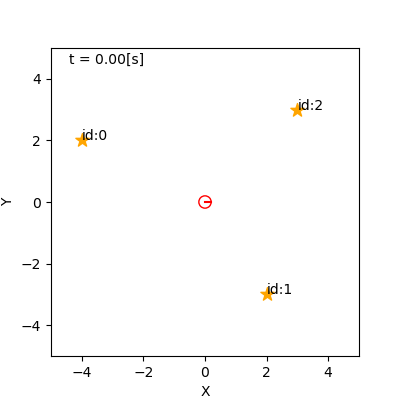

<IPython.core.display.Javascript object>


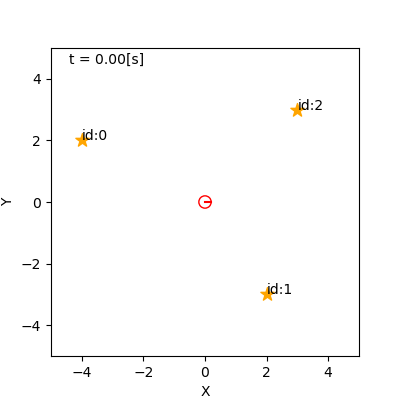

<IPython.core.display.Javascript object>


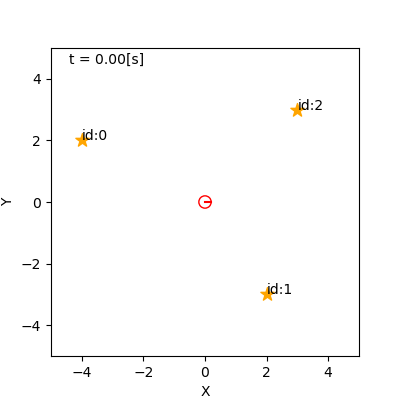

<IPython.core.display.Javascript object>


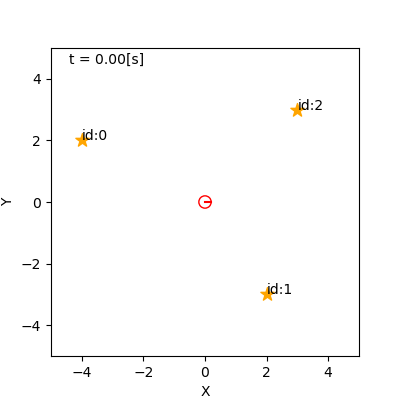

<IPython.core.display.Javascript object>


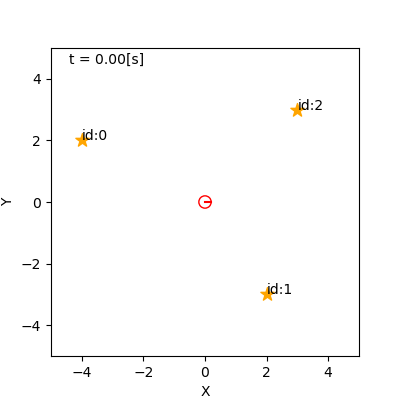

<IPython.core.display.Javascript object>


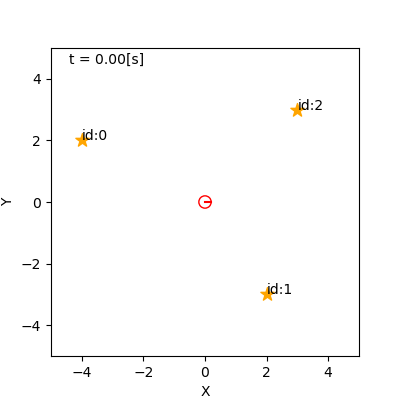

<IPython.core.display.Javascript object>


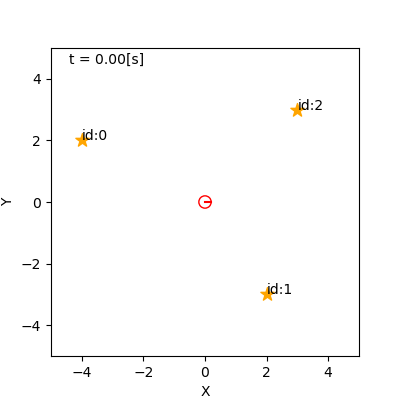

<IPython.core.display.Javascript object>


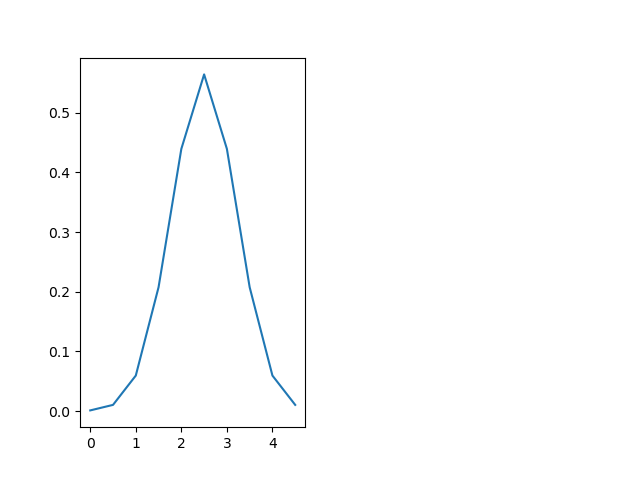

In [204]:
x = np.linspace(0, 5, 10, endpoint=False)

y = multivariate_normal.pdf(x, mean=2.5, cov=0.5)

fig1 = plt.figure()

ax = fig1.add_subplot(121)

ax.plot(x, y)

plt.show()


In [59]:
import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal

<IPython.core.display.Javascript object>


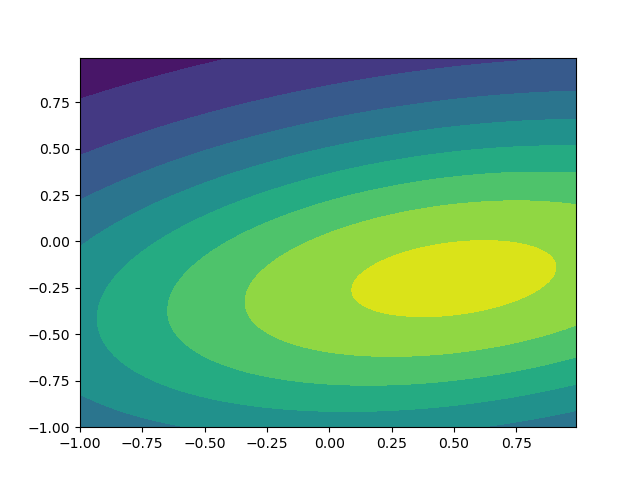

<IPython.core.display.Javascript object>


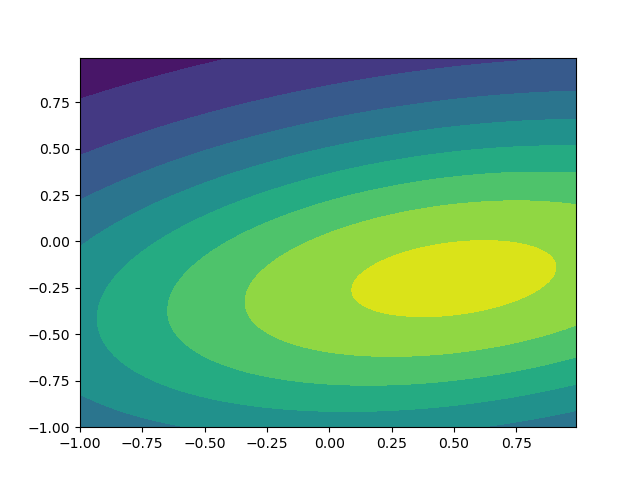

<IPython.core.display.Javascript object>


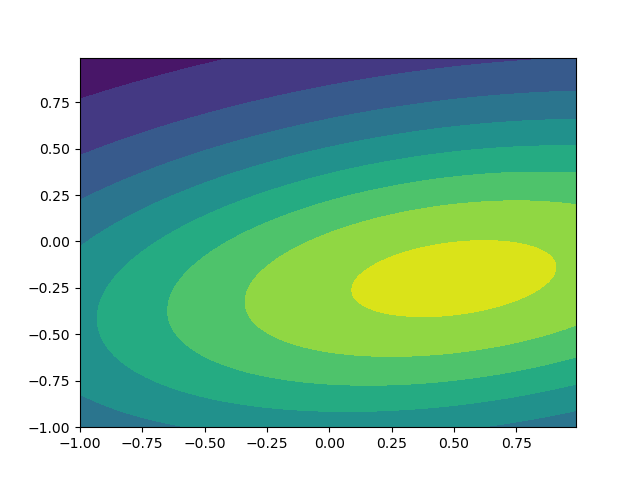

<IPython.core.display.Javascript object>


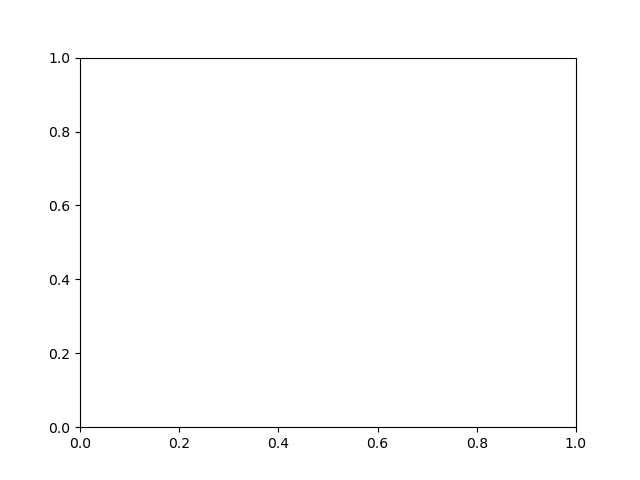

<IPython.core.display.Javascript object>


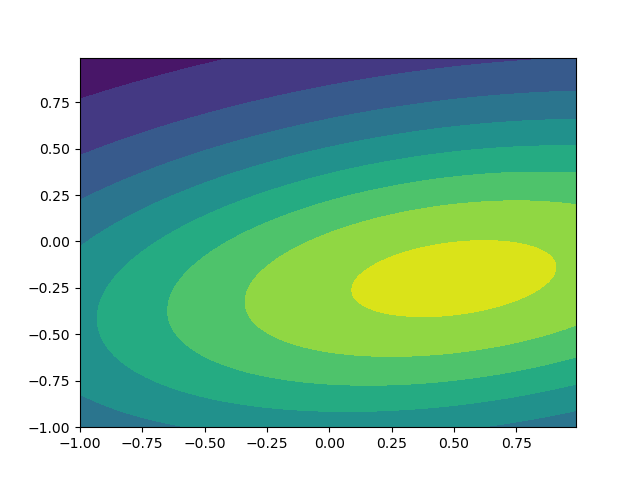

<IPython.core.display.Javascript object>


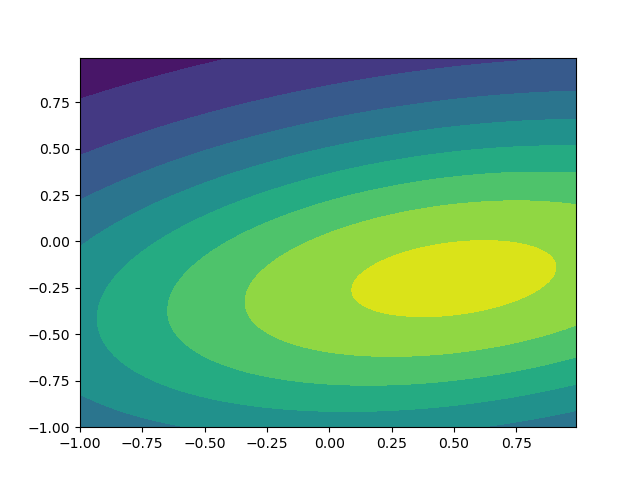

In [61]:
x, y = np.mgrid[-1:1:.01, -1:1:.01]

pos = np.dstack((x, y))
rv = multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
#rv = multivariate_normal(mean=None, cov=1, allow_singular=False)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, rv.pdf(pos))
plt.show()

In [81]:
print(np.diag([1e-10, 1e-10, 1e-10]))

[[1.e-10 0.e+00 0.e+00]
 [0.e+00 1.e-10 0.e+00]
 [0.e+00 0.e+00 1.e-10]]
